## Deep Learning Lab: ECE-00450107
## Meeting 2 - Part 2: Transfer Learning

#### Definitions and Imports:

In [1]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from collections import Counter
import scipy
from DL_Lab2_functions import *
torch.hub.set_dir('/usr/share/DL_exp/torch_cache')
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"
matplotlib.use('Agg')
warnings.filterwarnings('ignore')
%matplotlib tk

## Transfer Learning Using VGG16, on the Desserts Dataset 🍰
In this section, we will use the VGG16 model, pre-trained on the ImageNet dataset, and use transfer learning to classify images of desserts 🧁🍩🎂. 

#### Set fixed seeds to enable reproducing the results:

In [2]:
torch.cuda.empty_cache()

# Setting fixed seeds
seed = 2025
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
torch.use_deterministic_algorithms(True, warn_only=True)
torch.backends.cuda.matmul.allow_tf32 = False
torch.backends.cudnn.benchmark = False

#### Loading the Training Data

Let's load the desserts dataset and present some examples from it.

In [3]:
# Creating a desserts class from desserts.mat
mat_data = mat_data = scipy.io.loadmat('/usr/share/DL_exp/datasets/desserts224.mat')
class_names = {0: "canoli", 1: "moose", 2: "churros", 3: "creme brule", 4: "cupcake", 5: "doughnuts"}

train_data = mat_data['XTrain'].transpose(3, 0, 1, 2)
train_labels = mat_data['YTrain']
test_data = mat_data['XTest'].transpose(3, 0, 1, 2)
test_labels = mat_data['YTest']

class CustomDessertsDataset(Dataset):
    def __init__(self, data, labels, transform=None):
        self.data = data
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        image = self.data[index]
        label = self.labels[index].item()
        
        if self.transform:
            image = self.transform(image)
            
        return image, label-1

The train set contains 1920 images, divided into 6 sections:
Label 'canoli': 320 examples
Label 'moose': 320 examples
Label 'churros': 320 examples
Label 'creme brule': 320 examples
Label 'cupcake': 320 examples
Label 'doughnuts': 320 examples


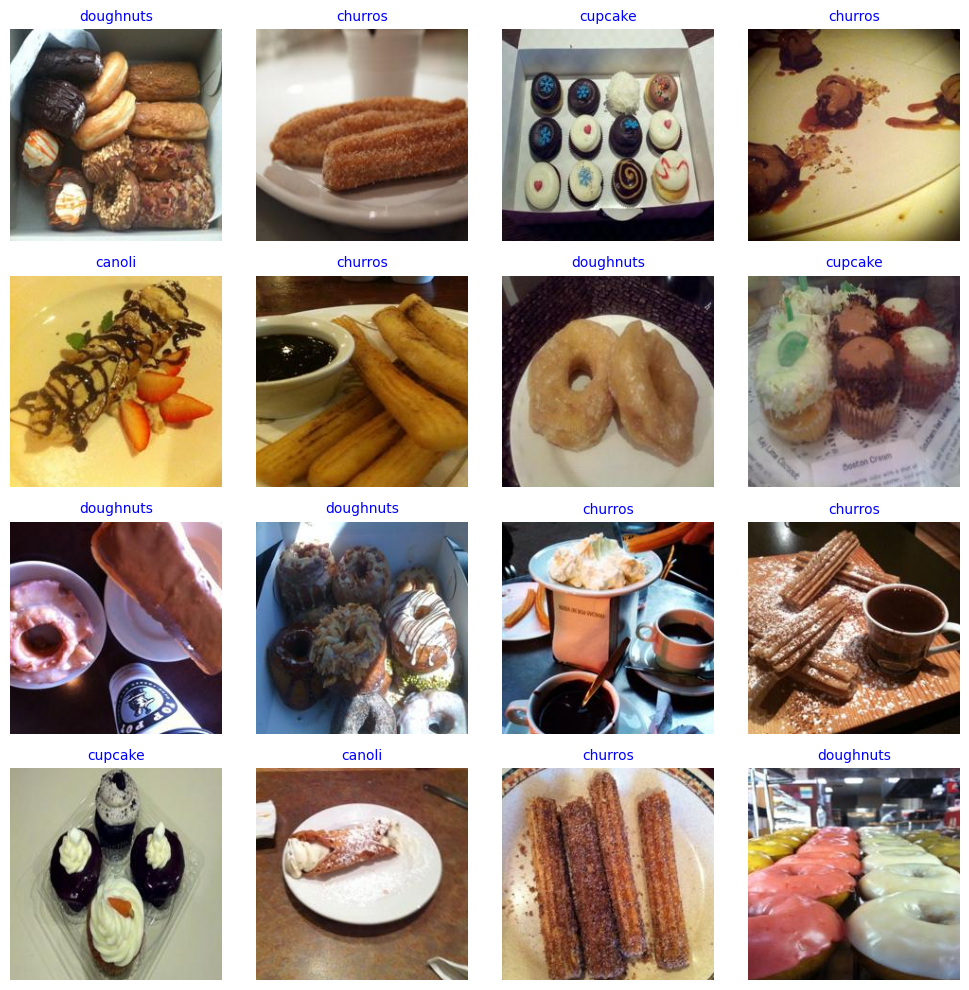

In [4]:
# Define a training set and print it
%matplotlib inline
train_set = CustomDessertsDataset(train_data, train_labels)

# Specify the struture of the dataset
all_labels = [label for image, label in train_set]
label_counts = Counter(all_labels)
num_classes = len(label_counts.items())
print(f"The train set contains {len(train_set)} images, divided into {num_classes} sections:")

plot_counts = []
plot_labels = []
for label, count in label_counts.items():
    print(f"Label '{class_names[label]}': {count} examples")
    plot_counts.append(count)
    plot_labels.append(label)

print_desserts(train_set, class_names)

#### Prepare Train and Test datasets for evaluation

Next, we will create a normilized version of the train and test sets in order to use them in the network.

In [5]:
# Set device
device = "cuda" if torch.cuda.is_available() else "cpu"

# Demonstrating that Vgg16 trained on imagnet brings nonsense results (what happens without transfer learning)
model = torchvision.models.vgg16(weights='IMAGENET1K_V1').to(device)

# The ImageNet statistics are known, so we can use them to normalize the data
mean_imn = [0.485, 0.456, 0.406]
std_imn = [0.229, 0.224, 0.225]
train_transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean_imn, std_imn)])
test_transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean_imn, std_imn)])

# Create train and test sets
train = CustomDessertsDataset(train_data, train_labels, transform=train_transform)
test = CustomDessertsDataset(test_data, test_labels, transform=test_transform)
train_loader, test_loader = prepare_dataloaders(train, test, batch_size=64)

###############################################################################################################################
# Flags for code enabling/disabling:
model_flag = 4# 1: Pre-trained+Classifier, 2: Transfer-Learning, 3: Fine-Tune training, 4: Training from scratch
###############################################################################################################################

#### Using the Pre-trained model with a Logistic Regression classifier

Let's see what the results of VGG16 pre-trained model are on the dessert dataset, without any transfer learning.  
In order to aim for our desired labels, we will and add an additional simple classification layer on top of it.

In [6]:
if (model_flag == 1):
    def get_model_outputs(model, dataloader, device):
        model.eval()
        outputs_list = []
        labels_list = []
        with torch.no_grad():
            for imgs, labels in dataloader:
                imgs = imgs.to(device)
                outputs = model(imgs)
                outputs_list.append(outputs.cpu())
                labels_list.append(labels.cpu())
        return torch.cat(outputs_list), torch.cat(labels_list)
    
    # Load the pre-trained VGG-16 model
    model = torchvision.models.vgg16(weights='IMAGENET1K_V1').to(device)

    # Calculate the VGG-16 results on our small train dataset
    vgg_results_train, real_labels_train = get_model_outputs(model, train_loader, device)

    # train the classifier using the VGG results as features
    linear_cls = LogisticRegression(random_state=0, solver='lbfgs', max_iter=100000, multi_class="multinomial")
    linear_cls.fit(vgg_results_train.cpu(), real_labels_train.cpu())

    # Now use the VGG16 + LR classifier on the test set
    vgg_results_test, real_labels_test = get_model_outputs(model, test_loader, device)
    lin_cls_pred = linear_cls.predict(vgg_results_test.cpu())

    # calculate accuracy of test set
    lin_cls_test_acc = accuracy_score(lin_cls_pred, real_labels_test.cpu())
    print(f"Test accuracy of the linear classifier: {lin_cls_test_acc*100:.2f}%")

#### Transfer Learning: un-freezing a small part of the Pre-trained Layers

Now we will change the last 2 fully-connected layers, but freeze all the others. Then we train.

In [7]:
if (model_flag == 2):
    def replace_layers(model: nn.Module, output_size: int = 6) -> nn.Module:
        # Freeze all of the model's parameters
        for param in model.parameters():
            param.requires_grad = False

        # the indices are according to VGG-16 drawing in the booklet
        TL_first_layer = 3
        TL_second_layer = 6
        # re-define linear layer so its weights will be restarted
        model.classifier[TL_first_layer] = nn.Linear(model.classifier[TL_first_layer].in_features, model.classifier[TL_second_layer].in_features)
        # re-define the last linear layer so it will match the nunber of classes in the new dataset
        model.classifier[TL_second_layer] = nn.Linear(model.classifier[TL_second_layer].in_features, output_size)  
        return model

    # Load the pre-trained VGG-16 model
    model = torchvision.models.vgg16(weights='IMAGENET1K_V1').to(device)
    print("Learnable parameters before and after freeze:")
    print(sum(p.numel() for p in model.parameters() if p.requires_grad))

 # Freezing the model weights, with the exeption of the last 2 FC layers    
    model = replace_layers(model, output_size=num_classes).to(device)
    print(sum(p.numel() for p in model.parameters() if p.requires_grad))

#### Fine-Tune: un-freezing the whole network

Now we will update the last layer, and retrain the whole model.

In [8]:
if (model_flag == 3):   
    # Load the pre-trained VGG-16 model
    model = torchvision.models.vgg16(weights='IMAGENET1K_V1').to(device)
    
    print("Learnable parameters before and after freeze:")
    print(sum(p.numel() for p in model.parameters() if p.requires_grad))

    # re-define the last layer so it will match the nunber of classes in the new dataset
    output_layer_ind = num_classes
    model.classifier[output_layer_ind] = nn.Linear(model.classifier[output_layer_ind].in_features, num_classes)
    print(sum(p.numel() for p in model.parameters() if p.requires_grad))    

#### Full Training: restarting the whole network and training from scratch

Now we will update the last layer, load an 'empty' model and train all the weights.

In [9]:
if (model_flag == 4):
    # Load a 'fresh' VGG-16 model
    model = torchvision.models.vgg16(weights=None).to(device)
    # re-define the last layer so it will match the nunber of classes in the new dataset
    output_layer_ind = num_classes
    model.classifier[output_layer_ind] = nn.Linear(model.classifier[output_layer_ind].in_features, num_classes)

Defining the Training Procedure, Same as Last Time

In [10]:
# Defining hyper-parameters
hparams = Hyper_Params()
hparams.lr = 0.0001
hparams.epochs = 15
hparams.scheduler_step_size = 5
hparams.scheduler_factor = 0.5
hparams.batch_size = 80

In [11]:
# Defining Loss, optimizer, Scheduler
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(list(p for p in model.parameters() if p.requires_grad), lr=hparams.lr)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=hparams.scheduler_step_size, gamma=hparams.scheduler_factor)
hparams.lines = len(train_loader)

In [12]:
# Create train and test sets
train_transform = transforms.Compose([transforms.ToTensor(), 
                                      transforms.Normalize(mean_imn, std_imn)])
test_transform = transforms.Compose([transforms.ToTensor(), 
                                     transforms.Normalize(mean_imn, std_imn)])

train = CustomDessertsDataset(train_data, train_labels, transform=train_transform)
test = CustomDessertsDataset(test_data, test_labels, transform=test_transform)
train_loader, test_loader = prepare_dataloaders(train, test, hparams.batch_size)

In [13]:
def evaluate(test_loader, model, loss_function):
    with torch.no_grad():
        loss = 0
        acc = 0
        for i, batch in enumerate(test_loader):
            data, target = batch
            output = model(data.to(device))
            batch_loss = loss_function(output, target.to(device))
            batch_acc = multi_class_accuracy(output, target.to(device))
            loss+= batch_loss
            acc+=batch_acc
        return loss.item()/len(test_loader),acc/len(test_loader)

#### Defining the Training Loop

Complete the code.

In [14]:
def train_with_scheduler(hparams: Hyper_Params,
                         train_loader: DataLoader,
                         test_loader: DataLoader,
                         model: nn.Module,
                         optimizer: optim.Optimizer,
                         scheduler: optim.lr_scheduler.LRScheduler,
                         loss_function: nn.Module,
                         acc_function: Callable) -> None:

    model = model.to(device)
    hparams.fig, (hparams.ax1, hparams.ax2) = plt.subplots(2, 1, figsize=(15, 9))
    print_performance_grid(Flag=True)
    iter_num = len(train_loader)

    # Set the model to training mode
    model.train()
    start_time = time.time() # time the start of training    
     # Training loop
    for epoch in range(hparams.epochs):      
        hparams.epoch_accuracy_train = np.zeros(len(train_loader))
        hparams.epoch_loss_train = np.zeros(len(train_loader))
      
        for i, batch in enumerate(train_loader):
            # get a new batch of images and labels
            data, target = batch
            target = target.reshape(target.shape[0]).to(device)

            # forward pass
            output = model(data.to(device))
            # TODO: Use the loss function on the output and target to get the train loss
            loss = loss_function(output, target)

            # backward pass
            # TODO: reset the optimizer's gradients
            optimizer.zero_grad()
            # TODO: complete the backward
            loss.backward()
            # TODO: complete the algorithm step
            optimizer.step()
               
            # save the loss and accuracy for the graph visualization
            hparams.epoch_accuracy_train[i] = multi_class_accuracy(output, target)
            hparams.epoch_loss_train[i] = loss.item()
                
            if (i == 0 and epoch == 0) or ((i+1) == iter_num):
                torch.cuda.empty_cache()
                model.eval()
                test_loss, test_accuracy = evaluate(test_loader, model, loss_function)
                print_performance(epoch, i, hparams, test_loss, test_accuracy)
                model.train()

            # TODO: Position A - should the scheduler.step() be here? Or...
            # ----- end of batch loop -----
        scheduler.step()
        # TODO: Position B - should the scheduler.step() be here?
        # ----- end of epoch loop -----

    plt.show()
    print(f"Total training took {time.time() - start_time:.2f} seconds")    

Train the Model

In [15]:
%matplotlib tk

# Training
train_with_scheduler(hparams, train_loader, test_loader, model, optimizer, scheduler, loss_function, multi_class_accuracy)
present_confusion_matrix(model, test_loader, class_names, device=device)

| Epoch No. | Iter No. | Train Loss | Train Accuracy | Test Loss | Test Accuracy |
----------------------------------------------------------------------------------
|     0     |    1     |    1.79    |      0.2       |   1.88    |     0.17      |
----------------------------------------------------------------------------------
|     0     |    24    |    1.8     |      0.18      |   1.79    |     0.25      |
----------------------------------------------------------------------------------
|     1     |    24    |    1.77    |      0.23      |    1.7    |     0.25      |
----------------------------------------------------------------------------------
|     2     |    24    |    1.72    |      0.27      |   1.68    |     0.28      |
----------------------------------------------------------------------------------
|     3     |    24    |    1.67    |      0.31      |   1.67    |      0.3      |
----------------------------------------------------------------------------------
|   